In [1]:
import tensorflow_datasets as tfds
from utils import * 
import cycle_gan
from discriminator import Discriminator
from discriminator_patchGAN import PatchGAN
from generator import *
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

%load_ext autoreload
%autoreload 2
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
builder = tfds.ImageFolder('datasets/normal2rusty/')
# print(builder.info)
train_summers = builder.as_dataset(split="trainA", as_supervised=True)
train_winters = builder.as_dataset(split="trainB", as_supervised=True)
test_summers = builder.as_dataset(split="testA", as_supervised=True)
test_winters = builder.as_dataset(split="testB", as_supervised=True)
# tfds.show_examples(ds, builder.info)

In [5]:
# dataset, metadata = tfds.load(
#     "cycle_gan/summer2winter_yosemite", with_info=True, as_supervised=True
# )

# train_summers, train_winters = dataset["trainA"], dataset["trainB"]
# test_summers, test_winters = dataset["testA"], dataset["testB"]

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [7]:
train_summers = (
    train_summers.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

train_winters = (
    train_winters.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

test_summers = (
    test_summers.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

test_winters = (
    test_winters.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(1)
)

In [19]:
sample_summer = next(iter(train_summers))
sample_winter = next(iter(train_winters))
sample_test_normal = next(iter(test_summers))
sample_test_rusty = next(iter(test_winters))

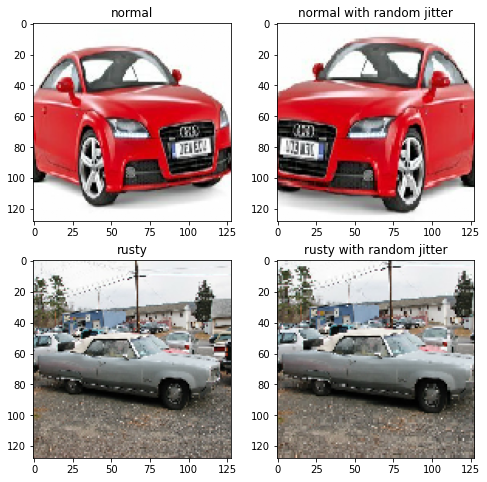

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('normal')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(222)
plt.title('normal with random jitter')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)

plt.subplot(223)
plt.title('rusty')
plt.imshow(sample_winter[0] * 0.5 + 0.5)

plt.subplot(224)
plt.title('rusty with random jitter')
plt.imshow(random_jitter(sample_winter[0]) * 0.5 + 0.5)

In [9]:
OUTPUT_CHANNELS = 3
IMG_DIM = getImageSize()
FILTERS = 64 # good results with 32

G = Generator(FILTERS, IMG_DIM, name="G")
F = Generator(FILTERS, IMG_DIM, name="F")

D_x = PatchGAN(FILTERS, IMG_DIM, name="D_x")
D_y = PatchGAN(FILTERS, IMG_DIM, name="D_y")

cyclegan_model = cycle_gan.CycleGAN(G, F, D_x, D_y, paper_generator_loss=True)
cyclegan_model.compile(0.0002, 0.5)

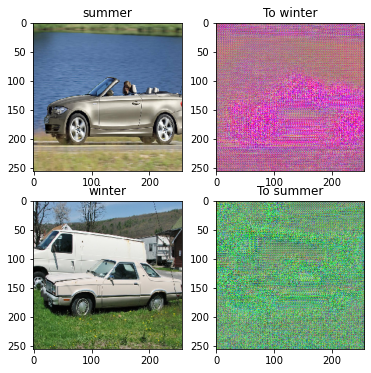

In [10]:
to_winter = G(sample_summer)
to_summer = F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["summer", "To winter", "winter", "To summer"]
plt.figure(figsize=(6, 6))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

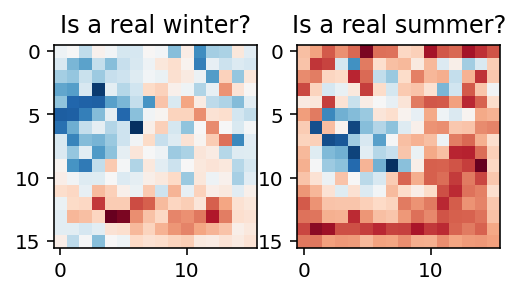

In [30]:
plt.figure(figsize=(4, 4))

plt.subplot(121)
plt.title('Is a real winter?')
plt.imshow(D_y(sample_winter)[0, ..., -1], cmap='RdBu_r')
# plt.imshow((D_y(sample_winter).numpy() + 1) / 2, cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real summer?')
plt.imshow(D_x(sample_summer)[0, ..., -1], cmap='RdBu_r')
# plt.imshow((D_x(sample_summer).numpy() + 1) / 2, cmap='RdBu_r')

plt.show()

In [10]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    G=G,
    F=F,
    D_x=D_x,
    D_y=D_y,
)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Latest checkpoint restored!!")

In [11]:
cyclegan_model.fit(tf.data.Dataset.zip((train_summers, train_winters)), batch_size=1, epochs=75)

Epoch 1/75
450/450 [==============================] - 484s 851ms/step - G_loss: 0.4534 - F_loss: 0.4805 - D_y_loss: 0.4109 - D_x_loss: 0.4175
Epoch 2/75
450/450 [==============================] - 385s 856ms/step - G_loss: 0.3383 - F_loss: 0.3217 - D_y_loss: 0.2670 - D_x_loss: 0.2681
Epoch 3/75
450/450 [==============================] - 385s 855ms/step - G_loss: 0.3894 - F_loss: 0.3276 - D_y_loss: 0.2483 - D_x_loss: 0.2608
Epoch 4/75
450/450 [==============================] - 383s 852ms/step - G_loss: 0.4657 - F_loss: 0.3480 - D_y_loss: 0.2202 - D_x_loss: 0.2577
Epoch 5/75
450/450 [==============================] - 383s 852ms/step - G_loss: 0.5400 - F_loss: 0.3646 - D_y_loss: 0.1990 - D_x_loss: 0.2538
Epoch 6/75
450/450 [==============================] - 384s 853ms/step - G_loss: 0.5308 - F_loss: 0.3844 - D_y_loss: 0.1989 - D_x_loss: 0.2466
Epoch 7/75
450/450 [==============================] - 383s 851ms/step - G_loss: 0.5318 - F_loss: 0.4270 - D_y_loss: 0.1964 - D_x_loss: 0.2340
Epoch 

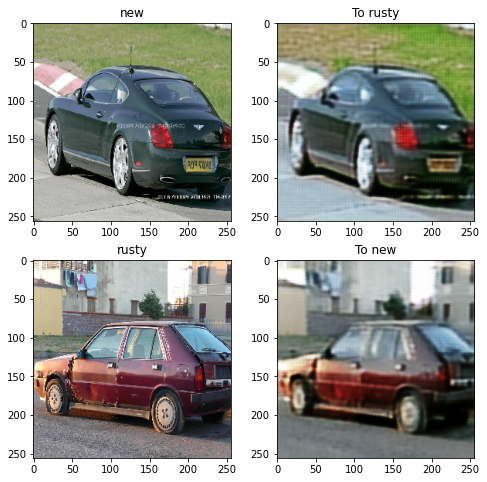

In [13]:
# 256 size, 64 filters, 12 resnets, 2 epochs.
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["new", "To rusty", "rusty", "To new"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

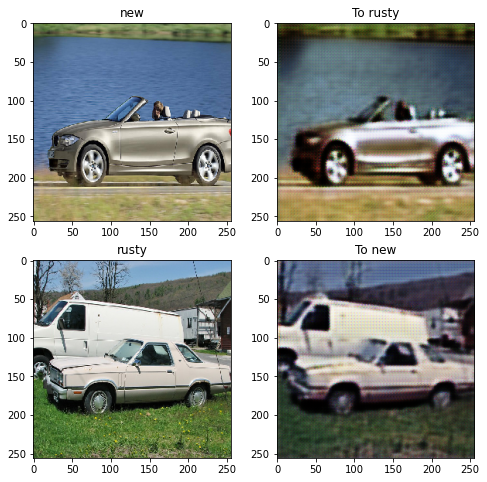

In [13]:
# 256 size, 64 filters, 3 resnets, 1 epoch.
to_winter = cyclegan_model.G(sample_summer)
to_summer = cyclegan_model.F(sample_winter)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["new", "To rusty", "rusty", "To new"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

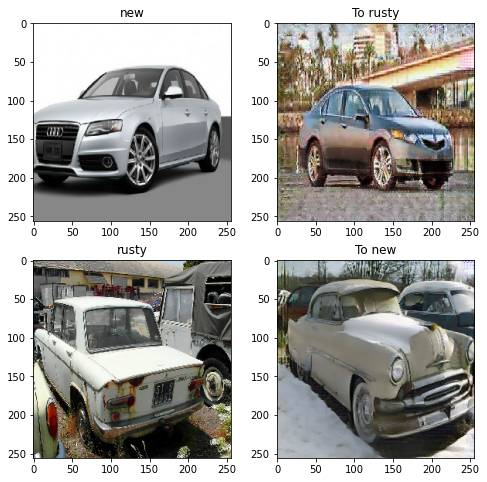

In [20]:
# 256 size, 64 filters, 9 resnets, 75 epochs.
to_winter = cyclegan_model.G(sample_test_normal)
to_summer = cyclegan_model.F(sample_test_rusty)

imgs = [sample_summer, to_winter, sample_winter, to_summer]
title = ["new", "To rusty", "rusty", "To new"]
plt.figure(figsize=(8,8))
for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
plt.show()

In [13]:
history = cyclegan_model.history

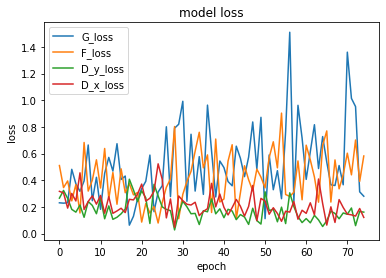

In [14]:
losses = history.history.keys()
# summarize history for loss
for loss in losses:
    plt.plot(history.history[loss])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([loss for loss in losses], loc='upper left')
plt.show()

In [22]:
ckpt_manager.save()

NameError: name 'ckpt_manager' is not defined

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_summers, train_winters)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print(".", end="")
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_summer) so that the progress of the model
    # is clearly visible.
    generate_images(G, sample_summer)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch + 1, ckpt_save_path))

    print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time() - start))

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.

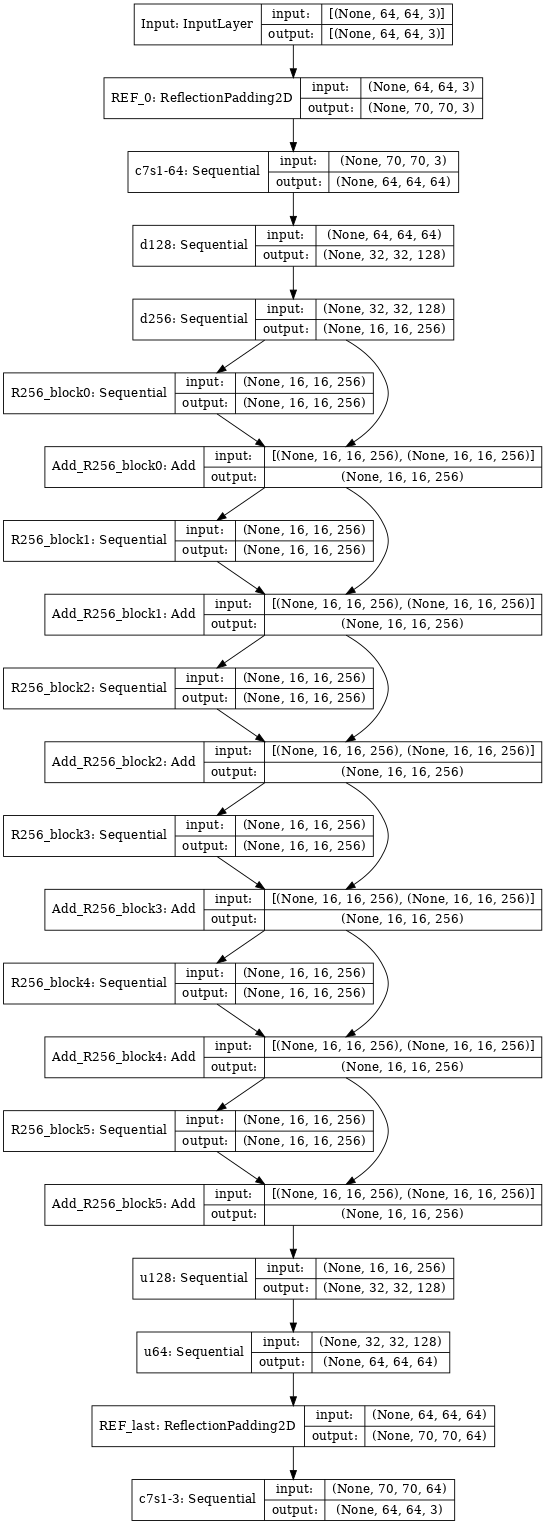

In [11]:
tf.keras.utils.plot_model(
    G, to_file="G.png", show_shapes=True, dpi=64, expand_nested=False
)

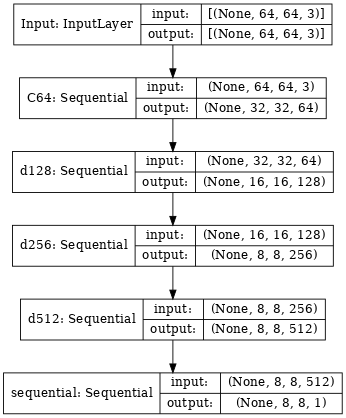

In [15]:
tf.keras.utils.plot_model(
    D_x, to_file="D_x.png", show_shapes=True, dpi=64, expand_nested=False
)

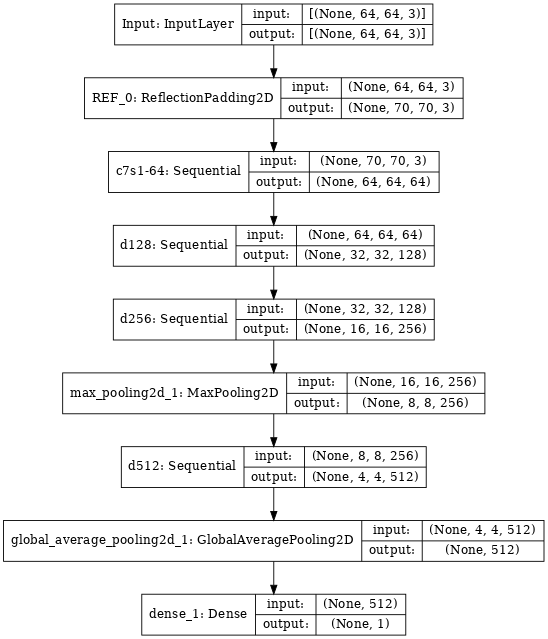

In [10]:
tf.keras.utils.plot_model(
    D_y, to_file="D_y.png", show_shapes=True, dpi=64, expand_nested=False
)